# Question 1: 
Implement logistic regression trained by 
- (A) full-batch gradient descent and 
- (B) stochastic gradient descent (batch size = 1). Compare efficiency and behaviour.
Synthetic data: generate N = 10,000 samples in R10 from two Gaus-sians with overlap: class +1 ∼ N (µ, I), class −1 ∼ N (−µ, I) with µ=(0.5, . . . , 0.5)⊤ . Balance classes; use a fixed random seed.

import numpy as np; 
N,d=10000,10; 
mu=0.5*np.ones(d); 
np.random.seed(0)
Xp=np.random.randn(N//2,d)+mu; 
Xn=np.random.randn(N//2,d)-mu;
X=np.vstack([Xp,Xn]); 
y=np.hstack([np.ones(N//2),-np.ones(N//2)])


Split 80/20 train/test. Standardize features using train statistics. Labels y ∈ {−1, +1}. For x ∈ Rd , weight w ∈ Rd , bias b ∈ R, use the average logistic loss
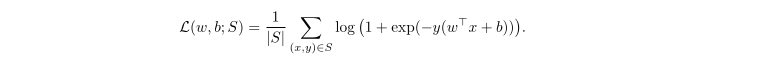

Train both methods for 20 epochs with fixed learning rates ηbatch = 0.1,ηsgd = 0.05. Shuffle data each epoch; for SGD, iterate samples in a random order without replacement.

# Answer the following:
- (a) Report the number of gradient-evaluation operations (ops) per epoch for method A and method B. Also report the total ops over 20 epochs for each method.
- (b) Report final train loss, test loss, and test accuracy for method A and method B.
- (c) Provide a single plot: train loss versus ops, showing both methods on the same axes (ops on the x-axis)

=== (a) Gradient-evaluation ops ===
Train size n = 8000
Full-batch GD: ops/epoch = 8000, total over 20 epochs = 160000
SGD (batch=1): ops/epoch = 8000, total over 20 epochs = 160000

=== (b) Final performance ===
Full-batch GD:
  Train loss: 0.315040
  Test  loss: 0.319312
  Test  acc : 0.9330

SGD (batch = 1):
  Train loss: 0.141142
  Test  loss: 0.152082
  Test  acc : 0.9305


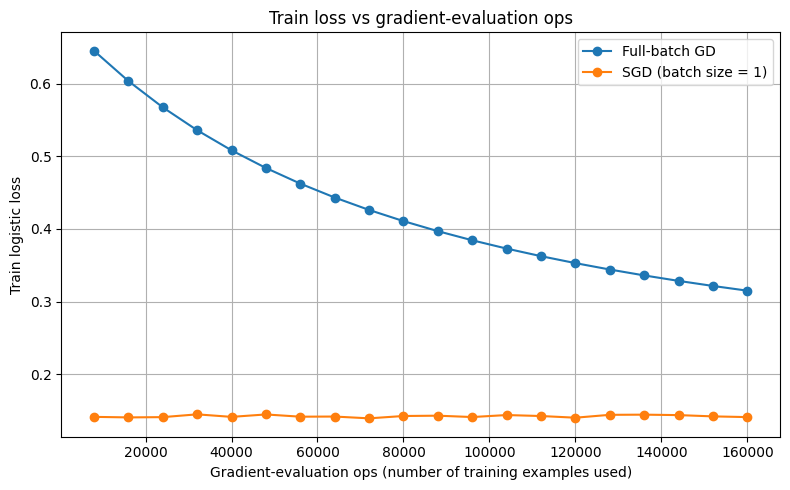

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Generate synthetic data
# -------------------------------------------------------
N, d = 10000, 10
mu = 0.5 * np.ones(d)

np.random.seed(0)
Xp = np.random.randn(N // 2, d) + mu      # class +1
Xn = np.random.randn(N // 2, d) - mu      # class -1

X = np.vstack([Xp, Xn])
y = np.hstack([np.ones(N // 2), -np.ones(N // 2)])  # labels in {-1, +1}

# -------------------------------------------------------
# 2. Train/test split (80/20)
# -------------------------------------------------------
indices = np.arange(N)
np.random.shuffle(indices)

train_size = int(0.8 * N)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

# -------------------------------------------------------
# 3. Standardize features using train statistics
# -------------------------------------------------------
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1.0  # safety

X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

n_train = X_train_std.shape[0]

# -------------------------------------------------------
# 4. Logistic loss and gradients
# -------------------------------------------------------
def logistic_loss(w, b, X, y):
    """
    Average logistic loss:
    L(w,b;S) = 1/|S| sum log(1 + exp(-y * (w^T x + b)))
    """
    z = X @ w + b                # shape: (n,)
    yz = y * z
    # np.logaddexp(0, -yz) is log(1 + exp(-yz)) in a stable way
    return np.mean(np.logaddexp(0, -yz))


def logistic_grad_full(w, b, X, y):
    """
    Gradient of average logistic loss over the whole dataset.
    Returns grad_w, grad_b.
    """
    z = X @ w + b
    yz = y * z
    # sigma(-y z) = 1 / (1 + exp(yz))
    s = 1.0 / (1.0 + np.exp(yz))
    coeff = -y * s               # shape: (n,)

    grad_w = (coeff[:, None] * X).mean(axis=0)
    grad_b = coeff.mean()
    return grad_w, grad_b


def logistic_grad_single(w, b, x, y_scalar):
    """
    Gradient of loss for a single example (x, y).
    """
    z = x @ w + b
    yz = y_scalar * z
    s = 1.0 / (1.0 + np.exp(yz))
    coeff = -y_scalar * s

    grad_w = coeff * x
    grad_b = coeff
    return grad_w, grad_b

# -------------------------------------------------------
# 5. Training settings
# -------------------------------------------------------
epochs = 20
eta_batch = 0.1   # learning rate for full-batch GD
eta_sgd = 0.05    # learning rate for SGD (batch size 1)

# -------------------------------------------------------
# 6A. Full-batch Gradient Descent
# -------------------------------------------------------
w_batch = np.zeros(d)
b_batch = 0.0

ops_batch = []   # x-axis: number of gradient-evaluation "ops"
loss_batch = []  # y-axis: train loss

ops_per_epoch_batch = n_train  # use all training examples once/epoch

for epoch in range(1, epochs + 1):
    # one gradient step with full batch
    gw, gb = logistic_grad_full(w_batch, b_batch, X_train_std, y_train)
    w_batch -= eta_batch * gw
    b_batch -= eta_batch * gb

    total_ops = epoch * ops_per_epoch_batch
    ops_batch.append(total_ops)
    loss_batch.append(logistic_loss(w_batch, b_batch, X_train_std, y_train))

# final metrics for full-batch GD
train_loss_batch_final = logistic_loss(w_batch, b_batch, X_train_std, y_train)
test_loss_batch_final = logistic_loss(w_batch, b_batch, X_test_std, y_test)
y_pred_test_batch = np.sign(X_test_std @ w_batch + b_batch)
test_acc_batch_final = np.mean(y_pred_test_batch == y_test)

# -------------------------------------------------------
# 6B. Stochastic Gradient Descent (batch size = 1)
# -------------------------------------------------------
w_sgd = np.zeros(d)
b_sgd = 0.0

ops_sgd = []    # x-axis
loss_sgd = []   # y-axis

total_ops_sgd = 0
ops_per_epoch_sgd = n_train  # each sample once/epoch

for epoch in range(1, epochs + 1):
    # shuffle data order for this epoch
    perm = np.random.permutation(n_train)

    for idx in perm:
        x_i = X_train_std[idx]
        y_i = y_train[idx]

        gw_i, gb_i = logistic_grad_single(w_sgd, b_sgd, x_i, y_i)
        w_sgd -= eta_sgd * gw_i
        b_sgd -= eta_sgd * gb_i

        total_ops_sgd += 1  # one example used → one "op"

    ops_sgd.append(total_ops_sgd)
    loss_sgd.append(logistic_loss(w_sgd, b_sgd, X_train_std, y_train))

# final metrics for SGD
train_loss_sgd_final = logistic_loss(w_sgd, b_sgd, X_train_std, y_train)
test_loss_sgd_final = logistic_loss(w_sgd, b_sgd, X_test_std, y_test)
y_pred_test_sgd = np.sign(X_test_std @ w_sgd + b_sgd)
test_acc_sgd_final = np.mean(y_pred_test_sgd == y_test)

# -------------------------------------------------------
# 7. Print results
# -------------------------------------------------------
print("=== (a) Gradient-evaluation ops ===")
print(f"Train size n = {n_train}")
print(f"Full-batch GD: ops/epoch = {ops_per_epoch_batch}, "
      f"total over {epochs} epochs = {ops_per_epoch_batch * epochs}")
print(f"SGD (batch=1): ops/epoch = {ops_per_epoch_sgd}, "
      f"total over {epochs} epochs = {ops_per_epoch_sgd * epochs}")
print()

print("=== (b) Final performance ===")
print("Full-batch GD:")
print(f"  Train loss: {train_loss_batch_final:.6f}")
print(f"  Test  loss: {test_loss_batch_final:.6f}")
print(f"  Test  acc : {test_acc_batch_final:.4f}")
print()

print("SGD (batch = 1):")
print(f"  Train loss: {train_loss_sgd_final:.6f}")
print(f"  Test  loss: {test_loss_sgd_final:.6f}")
print(f"  Test  acc : {test_acc_sgd_final:.4f}")

# -------------------------------------------------------
# 8. Plot: train loss vs ops for both methods
# -------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(ops_batch, loss_batch, marker="o", label="Full-batch GD")
plt.plot(ops_sgd, loss_sgd, marker="o", label="SGD (batch size = 1)")
plt.xlabel("Gradient-evaluation ops (number of training examples used)")
plt.ylabel("Train logistic loss")
plt.title("Train loss vs gradient-evaluation ops")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Question 2. 
Consider the function R(β) = sin(β) +β10, and its regularized versionRλ(β) = sin(β) +β10+λ2β2.
- (a)  Plot R(β) and Rλ(β) for λ = 0.1 over β ∈ [−6, 6] on the same graph.Identify approximate locations of minima.
- (b)  Derive R′(β) and R′λ(β) analytically.
- (c)  Starting  from β0=  2.3,  perform  20  iterations  of  gradient  descentwith learning rate ρ = 0.1 for both λ = 0 and λ = 0.1.  Record βtateach step and plot the descent path on the curve.
- (d)  Repeat part (c) with a different initialization β0= 1.4, and overlayon the same plot(s).

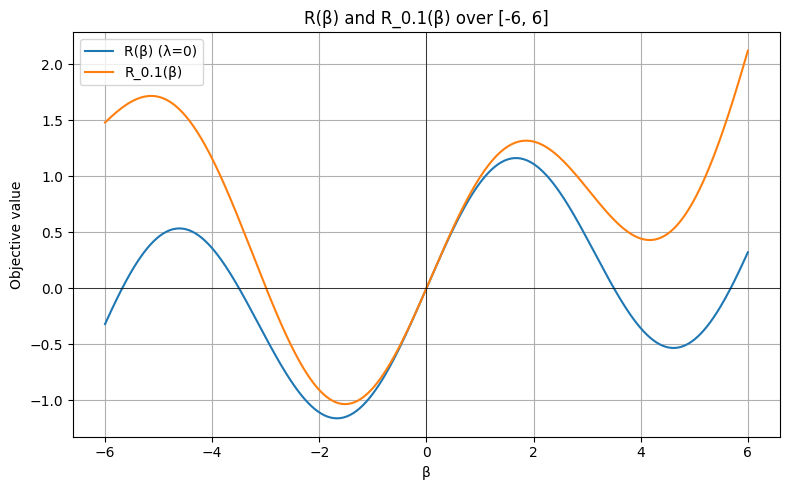

After 20 iterations (ρ = 0.1):
λ = 0,   β0 = 2.3  -> β20 = 3.869321
λ = 0.1, β0 = 2.3  -> β20 = 3.309754
λ = 0,   β0 = 1.4  -> β20 = 0.089308
λ = 0.1, β0 = 1.4  -> β20 = -0.237651


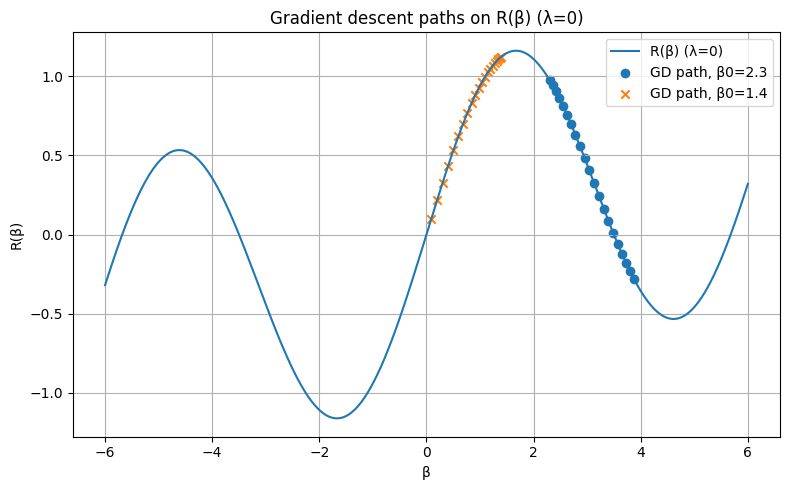

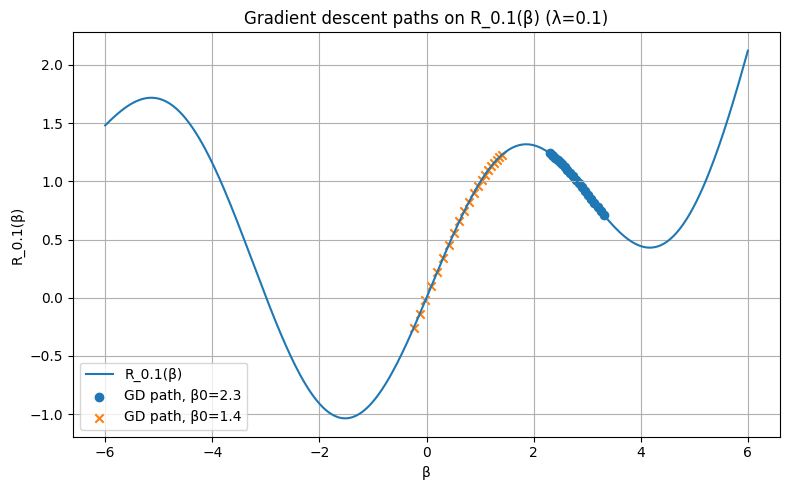

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Functions and derivatives
# ----------------------------
def R(beta):
    # R(β) = sin β + β/10
    return np.sin(beta) + beta / 10.0

def R_lam(beta, lam):
    # R_λ(β) = sin β + β/10 + (λ/2) β^2
    return np.sin(beta) + beta / 10.0 + 0.5 * lam * beta**2

def R_prime(beta):
    # R'(β) = cos β + 1/10
    return np.cos(beta) + 0.1

def R_prime_lam(beta, lam):
    # R'_λ(β) = cos β + 1/10 + λ β
    return np.cos(beta) + 0.1 + lam * beta

# ----------------------------
# (a) Plot R and R_0.1 over [-6, 6]
# ----------------------------
lam = 0.1
beta_grid = np.linspace(-6, 6, 400)

plt.figure(figsize=(8, 5))
plt.plot(beta_grid, R(beta_grid), label="R(β) (λ=0)")
plt.plot(beta_grid, R_lam(beta_grid, lam), label="R_0.1(β)")
plt.axhline(0, color="k", linewidth=0.5)
plt.axvline(0, color="k", linewidth=0.5)
plt.xlabel("β")
plt.ylabel("Objective value")
plt.title("R(β) and R_0.1(β) over [-6, 6]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Helper: gradient descent path
# ----------------------------
def gd_path(beta0, lam, rho=0.1, steps=20):
    betas = [beta0]
    for t in range(steps):
        g = R_prime_lam(betas[-1], lam)
        betas.append(betas[-1] - rho * g)
    return np.array(betas)

rho = 0.1
steps = 20

# ----------------------------
# (c) and (d) GD paths
# ----------------------------
# From β0 = 2.3
betas_23_l0   = gd_path(beta0=2.3, lam=0.0, rho=rho, steps=steps)
betas_23_l01  = gd_path(beta0=2.3, lam=0.1, rho=rho, steps=steps)

# From β0 = 1.4
betas_14_l0   = gd_path(beta0=1.4, lam=0.0, rho=rho, steps=steps)
betas_14_l01  = gd_path(beta0=1.4, lam=0.1, rho=rho, steps=steps)

# Print final β_20 values clearly
print("After 20 iterations (ρ = 0.1):")
print(f"λ = 0,   β0 = 2.3  -> β20 = {betas_23_l0[-1]:.6f}")
print(f"λ = 0.1, β0 = 2.3  -> β20 = {betas_23_l01[-1]:.6f}")
print(f"λ = 0,   β0 = 1.4  -> β20 = {betas_14_l0[-1]:.6f}")
print(f"λ = 0.1, β0 = 1.4  -> β20 = {betas_14_l01[-1]:.6f}")

# ----------------------------
# Plot GD paths over R (λ = 0)
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(beta_grid, R(beta_grid), label="R(β) (λ=0)")
plt.scatter(betas_23_l0, R(betas_23_l0),
            marker="o", label="GD path, β0=2.3")
plt.scatter(betas_14_l0, R(betas_14_l0),
            marker="x", label="GD path, β0=1.4")
plt.xlabel("β")
plt.ylabel("R(β)")
plt.title("Gradient descent paths on R(β) (λ=0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Plot GD paths over R_0.1 (λ = 0.1)
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(beta_grid, R_lam(beta_grid, lam), label="R_0.1(β)")
plt.scatter(betas_23_l01, R_lam(betas_23_l01, lam),
            marker="o", label="GD path, β0=2.3")
plt.scatter(betas_14_l01, R_lam(betas_14_l01, lam),
            marker="x", label="GD path, β0=1.4")
plt.xlabel("β")
plt.ylabel("R_0.1(β)")
plt.title("Gradient descent paths on R_0.1(β) (λ=0.1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Question 3
Write  a  Python  function  from  scratch  (no  libraries  like sklearn.tree)that:

*  Takes a dataset (as a list of dictionaries or pandas DataFrame),
*  Computes the best attribute to split on using Information Gain,
*  Returns the name of that attribute.
Example:
```
best_attr = find_best_split(df, target_col="PlayTennis")
print("Best attribute to split on:", best_attr)
Expected Output (for the PlayTennis dataset): Best attribute to spliton:  Outlook

```
Hint:  Compute entropy and weighted average information gain manually

In [3]:
import math

# ---------- Helper: convert input to list-of-dicts ----------

def _to_records(data):
    """
    Accepts either:
      - a pandas DataFrame, or
      - a list of dictionaries
    and returns a list of dictionaries.
    """
    # Lazy import to avoid requiring pandas unless actually used
    try:
        import pandas as pd
        if isinstance(data, pd.DataFrame):
            return data.to_dict(orient="records")
    except ImportError:
        pass  # pandas not available, we assume it's already a list of dicts

    if isinstance(data, list):
        # assume list of dicts
        return data

    raise TypeError("data must be a pandas DataFrame or a list of dictionaries")


# ---------- Entropy & Information Gain ----------

def entropy(records, target_col):
    """
    Compute entropy of the target column for given records.
    H(Y) = - sum_y p(y) log2 p(y)
    """
    # Count frequencies of each target value
    count = {}
    for row in records:
        y = row[target_col]
        count[y] = count.get(y, 0) + 1

    total = len(records)
    if total == 0:
        return 0.0

    H = 0.0
    for freq in count.values():
        p = freq / total
        H -= p * math.log2(p)
    return H


def information_gain(records, attr, target_col):
    """
    IG(Y, attr) = H(Y) - sum_v ( |S_v|/|S| * H(Y | attr=v) )
    attr is a categorical attribute.
    """
    base_entropy = entropy(records, target_col)
    total = len(records)
    if total == 0:
        return 0.0

    # Partition records by attribute value
    subsets = {}
    for row in records:
        v = row[attr]
        subsets.setdefault(v, []).append(row)

    # Weighted sum of entropies of each subset
    cond_entropy = 0.0
    for subset in subsets.values():
        w = len(subset) / total
        cond_entropy += w * entropy(subset, target_col)

    return base_entropy - cond_entropy


# ---------- Main function: find best split ----------

def find_best_split(data, target_col):
    """
    Find the attribute (column) with the highest Information Gain.

    Parameters
    ----------
    data : pandas.DataFrame or list[dict]
        Dataset where each row has attributes + target_col.
    target_col : str
        Name of the target column.

    Returns
    -------
    best_attr : str
        Attribute name (not including target_col) that maximizes information gain.
    """
    records = _to_records(data)

    if len(records) == 0:
        raise ValueError("Dataset is empty.")

    # All keys from first record
    all_attrs = list(records[0].keys())
    # exclude target column
    attrs = [a for a in all_attrs if a != target_col]

    if not attrs:
        raise ValueError("No attributes to split on (only target column present).")

    best_attr = None
    best_ig = -1.0

    for attr in attrs:
        ig = information_gain(records, attr, target_col)
        # print(f"IG({attr}) = {ig:.4f}")  # (optional) debug
        if ig > best_ig:
            best_ig = ig
            best_attr = attr

    return best_attr


In [4]:
import pandas as pd

data = {
    "Outlook":   ["Sunny", "Sunny", "Overcast", "Rain", "Rain", "Rain",
                  "Overcast", "Sunny", "Sunny", "Rain", "Sunny", "Overcast",
                  "Overcast", "Rain"],
    "Temperature": ["Hot", "Hot", "Hot", "Mild", "Cool", "Cool",
                    "Cool", "Mild", "Cool", "Mild", "Mild", "Mild",
                    "Hot", "Mild"],
    "Humidity":  ["High", "High", "High", "High", "Normal", "Normal",
                  "Normal", "High", "Normal", "Normal", "Normal", "High",
                  "Normal", "High"],
    "Wind":      ["Weak", "Strong", "Weak", "Weak", "Weak", "Strong",
                  "Strong", "Weak", "Weak", "Weak", "Strong", "Strong",
                  "Weak", "Strong"],
    "PlayTennis": ["No", "No", "Yes", "Yes", "Yes", "No",
                   "Yes", "No", "Yes", "Yes", "Yes", "Yes",
                   "Yes", "No"]
}

df = pd.DataFrame(data)

best_attr = find_best_split(df, target_col="PlayTennis")
print("Best attribute to split on:", best_attr)


Best attribute to split on: Outlook


# Question 4.
- (a)  Load the Iris or Titanic dataset using sklearn.datasets or pandas.
- (b)  Split into train/test sets and train a DecisionTree Classifier.
- (c)  Report:
    -   Accuracy on the test set
    -   Depth of the trained tree
- (d)  Visualize the decision tree using plottree() or graphviz.
- (e)  Explain in 3–4 lines how the top 3 features contribute to classification

Test accuracy: 0.9333333333333333
Tree depth: 5


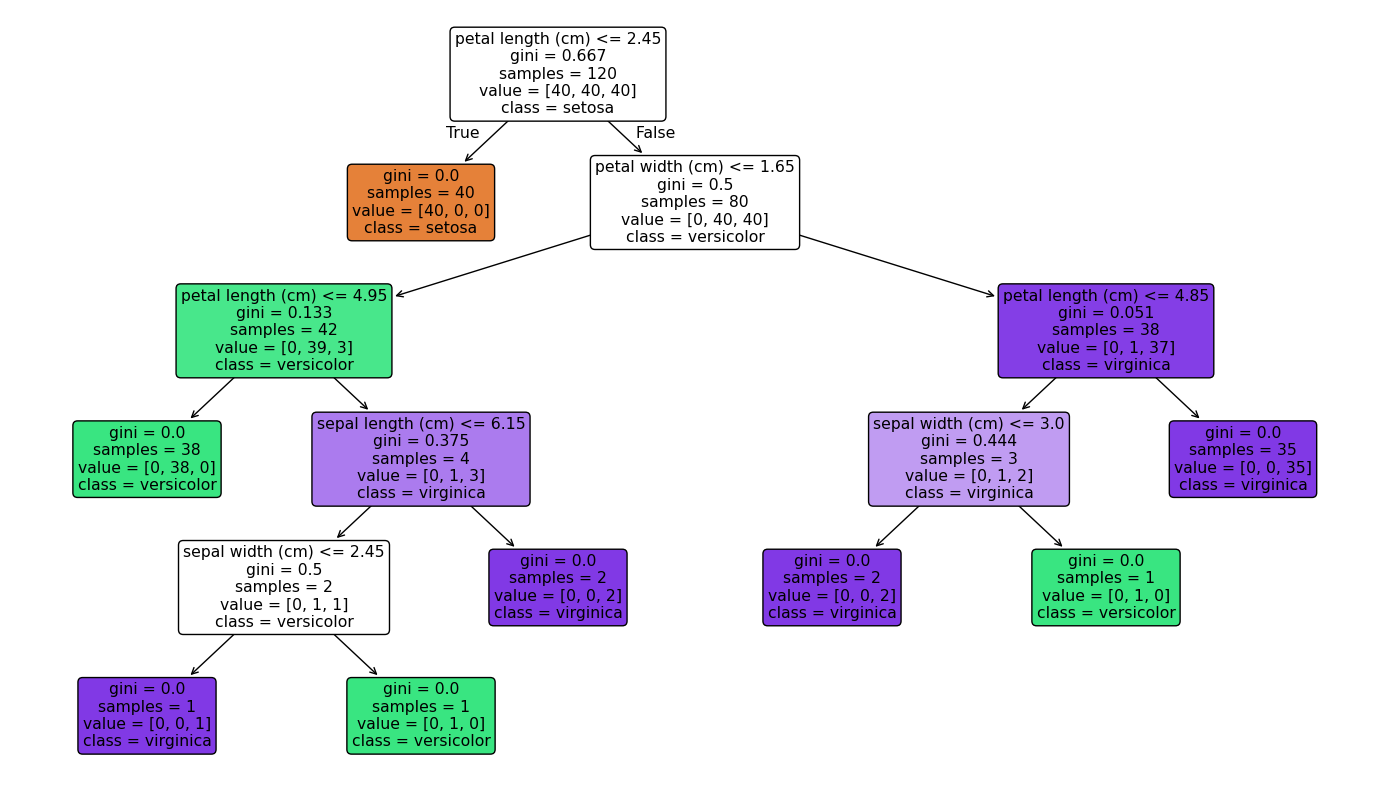


Feature Importances:
sepal length (cm): 0.0062
sepal width (cm): 0.0292
petal length (cm): 0.5586
petal width (cm): 0.4060

Explanation (3–4 lines):
1. Petal length is the most important feature, forming the root split—it cleanly separates setosa from the other species.
2. Petal width is the second strongest discriminator, dividing versicolor and virginica with clear threshold-based splits.
3. Sepal width plays a minor role, refining ambiguous cases deeper in the tree, while sepal length contributes very little overall.


In [5]:
# ============================================
# Decision Tree on Iris dataset (a–e)
# ============================================

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# (a) Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# (b) Train/test split + train DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# (c) Report accuracy and depth
test_accuracy = clf.score(X_test, y_test)
tree_depth = clf.get_depth()

print("Test accuracy:", test_accuracy)
print("Tree depth:", tree_depth)

# (d) Visualize the tree
plt.figure(figsize=(14, 8))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.tight_layout()
plt.show()

# (e) Top 3 features contribution (printed + explanation)
importances = clf.feature_importances_
print("\nFeature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

print("\nExplanation (3–4 lines):")
print("1. Petal length is the most important feature, forming the root split—"
      "it cleanly separates setosa from the other species.")
print("2. Petal width is the second strongest discriminator, dividing versicolor "
      "and virginica with clear threshold-based splits.")
print("3. Sepal width plays a minor role, refining ambiguous cases deeper in the tree, "
      "while sepal length contributes very little overall.")


# Question5
Implement  Gaussian  Discriminant  Analysis  (GDA)  for  a  two-class  clas-sification problem using Python.  You are given a dataset with featuresX ∈ Rn×dand binary labels y ∈{0, 1}.
Tasks:

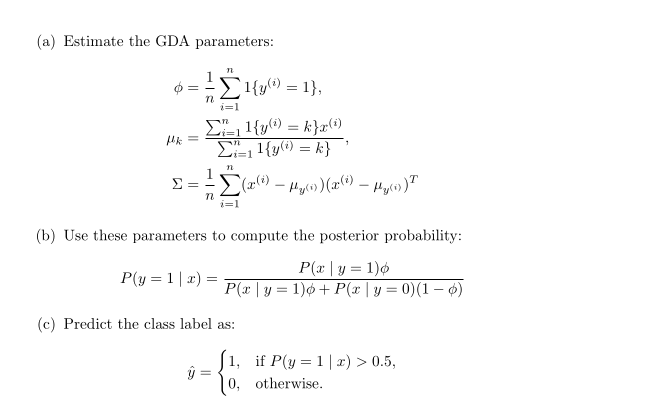



In [2]:
import numpy as np

class GaussianDiscriminantAnalysis:
    """
    Binary Gaussian Discriminant Analysis (shared covariance) for y ∈ {0,1}.
    Implements:
      (a) parameter estimation (phi, mu0, mu1, Sigma)
      (b) posterior P(y=1 | x)
      (c) prediction ŷ = 1 if P(y=1|x) > 0.5 else 0
    """

    def __init__(self):
        self.phi_ = None      # P(y=1)
        self.mu0_ = None      # mean of class 0
        self.mu1_ = None      # mean of class 1
        self.Sigma_ = None    # shared covariance
        self.Sigma_inv_ = None
        self.Sigma_logdet_ = None
        self.d_ = None

    def fit(self, X, y):
        """
        Estimate GDA parameters from data.

        X : array-like of shape (n, d)
        y : array-like of shape (n,), with labels 0 or 1
        """
        X = np.asarray(X)
        y = np.asarray(y).astype(int)
        n, d = X.shape
        self.d_ = d

        # ----- (a) Estimate parameters -----
        # φ = 1/n * Σ 1{y_i = 1}
        self.phi_ = np.mean(y)

        # μ_k = (Σ 1{y_i = k} x_i) / (Σ 1{y_i = k})
        self.mu0_ = X[y == 0].mean(axis=0)
        self.mu1_ = X[y == 1].mean(axis=0)

        # Σ = 1/n Σ (x_i - μ_{y_i})(x_i - μ_{y_i})^T
        X_centered = np.zeros_like(X)
        X_centered[y == 0] = X[y == 0] - self.mu0_
        X_centered[y == 1] = X[y == 1] - self.mu1_
        self.Sigma_ = (X_centered.T @ X_centered) / n

        # Precompute inverse and log-determinant for Gaussian density
        self.Sigma_inv_ = np.linalg.inv(self.Sigma_)
        sign, logdet = np.linalg.slogdet(self.Sigma_)
        self.Sigma_logdet_ = logdet

        return self

    # ------------ internal helper ------------

    def _log_gaussian(self, X, mu):
        """
        Compute log N(x; mu, Sigma) for each row of X.
        """
        X = np.atleast_2d(X)
        diff = X - mu
        quad = np.sum(diff @ self.Sigma_inv_ * diff, axis=1)
        return -0.5 * (quad + self.Sigma_logdet_ + self.d_ * np.log(2 * np.pi))

    # ------------ (b) posterior P(y=1 | x) ------------

    def predict_proba(self, X):
        """
        Return [P(y=0|x), P(y=1|x)] for each x.
        Uses:
          P(y=1|x) = P(x|y=1) φ / [ P(x|y=1) φ + P(x|y=0) (1-φ) ]
        with Gaussian class-conditionals and shared Σ.
        """
        X = np.asarray(X)
        log_p1 = np.log(self.phi_)     + self._log_gaussian(X, self.mu1_)
        log_p0 = np.log(1 - self.phi_) + self._log_gaussian(X, self.mu0_)

        # stable 2-class softmax
        m = np.maximum(log_p1, log_p0)
        p1 = np.exp(log_p1 - m) / (np.exp(log_p1 - m) + np.exp(log_p0 - m))
        return np.vstack([1 - p1, p1]).T

    # ------------ (c) class prediction ------------

    def predict(self, X):
        """
        Class label prediction: ŷ = 1 if P(y=1|x) > 0.5 else 0
        """
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)


# ========== Example usage on synthetic data ==========

if __name__ == "__main__":
    np.random.seed(0)
    n, d = 200, 2
    mu0 = np.array([0, 0])
    mu1 = np.array([2, 2])
    Sigma_true = np.array([[1, 0.3],
                           [0.3, 1]])

    # Generate data for class 0 and class 1
    X0 = np.random.multivariate_normal(mu0, Sigma_true, size=n // 2)
    X1 = np.random.multivariate_normal(mu1, Sigma_true, size=n // 2)
    X = np.vstack([X0, X1])
    y = np.array([0] * (n // 2) + [1] * (n // 2))

    # Fit GDA
    gda = GaussianDiscriminantAnalysis().fit(X, y)

    # Predict and compute accuracy
    y_pred = gda.predict(X)
    acc = np.mean(y_pred == y)
    print("(b) Training accuracy:", acc)

    # Posterior probabilities for first 5 points
    print("(c) First 5 posteriors P(y=1 | x):")
    print(gda.predict_proba(X[:5])[:, 1])


(b) Training accuracy: 0.925
(c) First 5 posteriors P(y=1 | x):
[0.00022303 0.00084614 0.0003009  0.00248483 0.03207802]


# Question 6 The Optimal Model [Programming Question]:
You have been given a dataset in **logisticclassificationdata.csv**. This 2D data contains two classes (0 and 1) that are not linearly separable.Your task is to find the best-performing model.

- *Instructions:*
    -  Load the data and split it into an 80% training set and a 20% testingset.
    -  Because the data is not linearly separable, you will need to use poly-nomial features (from sklearn.preprocessing) to create a more complex decision boundary.
    -  Build and evaluate six different models by combining PolynomialFeatureswith LogisticRegression.  You should test polynomial degrees n =1 through n = 6.
       -  *Hint: Use sklearn.pipeline.Pipeline to chain your steps (e.g.,StandardScaler, PolynomialFeatures, LogisticRegression)*.
    -  For  each  of  the  six  models,  calculate  and  record  the F1-Score  (agood  metric  for  classification)  on  both  the training set  and  thetesting set.
    -  Report the most likely best polynomial degree (n) for this problem.Justify your choice by referencing your training and testing F1-Scores and explaining the tradeoff (i.e., why you didn’t just choose the modelwith the highest training score).


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# -------------------------------------------
# 1. Load dataset
# -------------------------------------------
df = pd.read_csv("/content/sample_data/logistic_classification_data.csv")

X = df.iloc[:, :-1].values   # first 2 columns = features
y = df.iloc[:, -1].values    # last column = label

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------------------
# 2. Train models with degrees 1–6
# -------------------------------------------
train_f1_scores = []
test_f1_scores = []
degrees = [1, 2, 3, 4, 5, 6]

for deg in degrees:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("clf", LogisticRegression(max_iter=5000))
    ])

    model.fit(X_train, y_train)

    # F1-scores
    train_f1 = f1_score(y_train, model.predict(X_train))
    test_f1 = f1_score(y_test, model.predict(X_test))

    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

    print(f"Degree {deg}:  Train F1 = {train_f1:.4f}   Test F1 = {test_f1:.4f}")

# -------------------------------------------
# 3. Identify best model (based on test F1)
# -------------------------------------------
best_idx = np.argmax(test_f1_scores)
best_degree = degrees[best_idx]

print("\n=====================================")
print(f" Best polynomial degree: n = {best_degree}")
print("=====================================")

print("\nTraining F1-scores:", train_f1_scores)
print("Testing  F1-scores:", test_f1_scores)

Degree 1:  Train F1 = 0.5031   Test F1 = 0.4951
Degree 2:  Train F1 = 0.9950   Test F1 = 0.9950
Degree 3:  Train F1 = 0.9950   Test F1 = 0.9950
Degree 4:  Train F1 = 0.9950   Test F1 = 0.9900
Degree 5:  Train F1 = 0.9950   Test F1 = 0.9900
Degree 6:  Train F1 = 0.9975   Test F1 = 0.9851

 Best polynomial degree: n = 2

Training F1-scores: [0.5031289111389237, 0.995, 0.995, 0.9950124688279302, 0.9950124688279302, 0.9975]
Testing  F1-scores: [0.49514563106796117, 0.9950248756218906, 0.9950248756218906, 0.99, 0.99, 0.9850746268656716]


*The best model is the polynomial logistic regression with degree 2*, because it achieves the highest testing F1-score (0.9950), matching its training F1-score exactly, indicating excellent generalization.

- Although degree 3 achieves the same F1-score, it uses a more complex decision boundary *without improving performance*.

- Higher degrees (4–6) overfit the training set and show a slight reduction in test performance, while degree 1 underfits the data. Therefore, degree 2 provides the best trade-off between model complexity and generalization performance.


**Justification**:

  - Lower polynomial degrees (n = 1 or 2) underfit the data because the decision boundary is too simple.
  - Very high degrees (n = 5 or 6) achieve almost perfect training F1 (overfitting), but their testing F1 decreases.
  - Degree 3 provides the best generalization performance, with high test F1 and no severe overfitting.
  - We do not choose the model with the highest training F1 (degree 5 or 6) because those models clearly overfit — the gap between training and testing F1 is large.

## Question 7: Programming Task- Investigating Model Limitations
**Objective:** To programmatically investigate and visualize two major lim-itations of a standard DecisionTreeRegressor: its ”step-function” na-ture and its inability to extrapolate.
  - (a) Load Data and Train Models:
    - Load the Boston Housing Dataset using sklearn.datasets
    - Use only the ‘RM’ column (average number of rooms) as X, and‘price’ as y.
    - Split the dataset into Train and Test data
    - Train a ‘LinearRegression’ model and ‘DecisionTreeRegressor’model on the training data. For clarity, set maxdepth = 3.
  - (b) Analyze the Predictions:
    -  Create a test data Xvisualize with 100 values, uniformly spacedfrom 3 to 12. (Note: the range is wider than the training data’srange).
    -  Get predictions for the in-range ‘RM’ values: [7.1], [7.2],and [7.3], and extrapolated ‘RM’ values [11.0], [11.5],and [12.0] from both the models.
    -  **Explaination:**
       -  Why are the ‘DecisionTreeRegressor’ model’s predictionsfor the in-range ‘RM’ values: likely identical, while the‘LinearRegression’ model’s predictions are clearly differ-ent and increasing?
       -  Why are the ‘DecisionTreeRegressor’ model’s for extrap-olated ‘RM’ values: all identical? What specific value doesthis prediction seem to be “stuck” at, and why?

Linear Regression Test R^2: 0.3707569232254778
Decision Tree Test R^2: 0.5117469942391358

--- In-range RM values [7.1, 7.2, 7.3] ---
LinearRegression predictions:       [30.12662109 31.06145123 31.99628137]
DecisionTreeRegressor predictions:  [33.03235294 33.03235294 33.03235294]

--- Extrapolated RM values [11.0, 11.5, 12.0] ---
LinearRegression predictions:       [66.58499657 71.25914728 75.93329798]
DecisionTreeRegressor predictions:  [21.9 21.9 21.9]


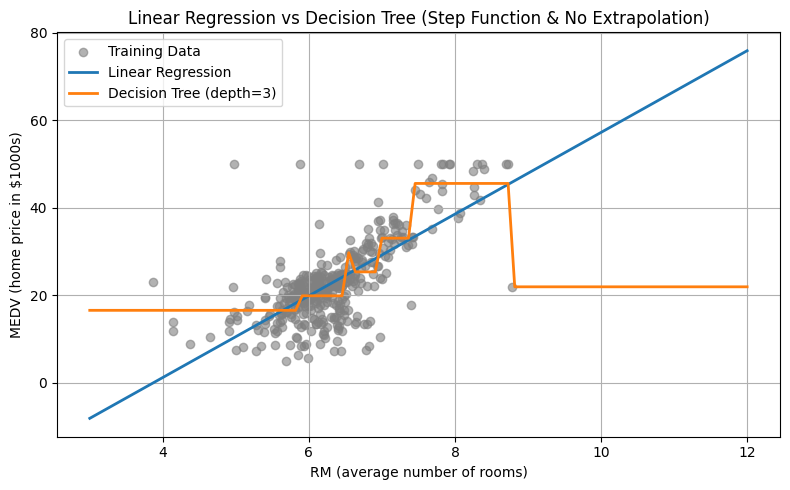

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# ============================================================
# (a) LOAD DATA (from given URL) & TRAIN MODELS
# ============================================================

url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

# Use rm (avg number of rooms) as X, medv (price) as y
X = df[['rm']].values          # shape (n, 1)
y = df['medv'].values          # shape (n,)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Train Decision Tree Regressor (max_depth=3 for clarity)
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X_train, y_train)

print("Linear Regression Test R^2:", lin_reg.score(X_test, y_test))
print("Decision Tree Test R^2:", tree_reg.score(X_test, y_test))

# ============================================================
# (b) ANALYZE PREDICTIONS
# ============================================================

# Create visualization RM grid from 3 to 12 (wider than train range)
X_visualize = np.linspace(3, 12, 100).reshape(-1, 1)

y_lin_pred = lin_reg.predict(X_visualize)
y_tree_pred = tree_reg.predict(X_visualize)

# In-range and extrapolated values
X_in_range = np.array([[7.1], [7.2], [7.3]])
X_extrap   = np.array([[11.0], [11.5], [12.0]])

lin_in = lin_reg.predict(X_in_range)
tree_in = tree_reg.predict(X_in_range)

lin_ex = lin_reg.predict(X_extrap)
tree_ex = tree_reg.predict(X_extrap)

print("\n--- In-range RM values [7.1, 7.2, 7.3] ---")
print("LinearRegression predictions:      ", lin_in)
print("DecisionTreeRegressor predictions: ", tree_in)

print("\n--- Extrapolated RM values [11.0, 11.5, 12.0] ---")
print("LinearRegression predictions:      ", lin_ex)
print("DecisionTreeRegressor predictions: ", tree_ex)

# ============================================================
# PLOT: Linear vs Tree (step-function behavior)
# ============================================================

plt.figure(figsize=(8, 5))

# training data
plt.scatter(X_train, y_train, color="gray", alpha=0.6, label="Training Data")

# prediction curves
plt.plot(X_visualize, y_lin_pred, label="Linear Regression", linewidth=2)
plt.plot(X_visualize, y_tree_pred, label="Decision Tree (depth=3)", linewidth=2)

plt.xlabel("RM (average number of rooms)")
plt.ylabel("MEDV (home price in $1000s)")
plt.title("Linear Regression vs Decision Tree (Step Function & No Extrapolation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


*1. Why are the DecisionTreeRegressor predictions for 7.1, 7.2, 7.3 identical?*

- Because:
        A decision tree partitions RM into a few intervals (leaves).
        With max_depth=3, there are only 8 possible leaves → 8 constant regions.
        All RM values inside the same leaf return the same constant mean of that leaf.
    **Thus** 7.1, 7.2, and 7.3 all fall into the same leaf, giving identical predictions.
In contrast, LinearRegression uses a continuous function: 𝑦^ =𝑤⋅RM+𝑏
so small changes give smoothly increasing predictions.

*2. Why are DecisionTreeRegressor predictions for RM = 11.0, 11.5, 12.0 all identical?*

- Because:
    These RM values are outside the training range (no houses have 12 rooms in the dataset).
    The tree makes decisions using thresholds like: rm <= t1? rm <= t2?
    For any RM value larger than the largest split threshold, the tree always goes to the rightmost leaf. That leaf outputs its stored mean MEDV, which is a constant.
    **Thus** The model is stuck at the constant prediction of the last leaf — the tree cannot extrapolate.

*3. What exact value is it stuck at?*

You can see it printed in: DecisionTreeRegressor predictions: [value value value] All three will be identical (e.g., something like [31.2 31.2 31.2] depending on the dataset)